### Code used for Chapter 7: Comparisons. 1D DFT.

Import libraries.

The detect_peaks.py is from:
https://github.com/demotu/BMC/blob/master/functions/detect_peaks.py

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy import integrate
import time
import pyfftw
from numba import jit
from detect_peaks import detect_peaks
%matplotlib inline

In chapter 4, section 4.3, it was found that the order of convergence of the 2D strong-stability preserving 3rd-order Runge-Kutta with 4th-order central difference scheme does not actually preserve the intended order of convergence.

Here, a 1D strong-stability preserving 2nd-order Runge-Kutta time-stepping with 2nd-order accuracy central difference scheme is used. This is for reasons of computational cost and since the order of convergence is limited to first-order in space anyway.

For more details on the strong-stability preserving Runge-Kutta methods, see [Gottlieb et. al](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.29.497&rep=rep1&type=pdf).

The shift/roll algorithm is used here (see 2D_Strang_SSP_RK3.ipynb for more details on this algorithm).

In [13]:
@jit(nopython=True)
def shift(A,num):
    E = np.empty_like(A)
    F = np.empty_like(A)
    G = np.empty_like(A)
    H = np.empty_like(A)
    
    E[:num] = A[-num:]
    E[num:] = A[:-num]
    F[:-num] = A[num:]
    F[-num:] = A[:num]
    
    G[:,:num] = A[:,-num:]
    G[:,num:] = A[:,:-num]
    H[:,:-num] = A[:,num:]
    H[:,-num:] = A[:,:num]
    return E + F + G + H

@jit(nopython=True)
def centralDiff(A,h,delta):
    A = A**3
    D = -1.*shift(A,2)+ 16.*shift(A,1) - 60.*A
    return 1./delta * D/(12.*h**2)

@jit(nopython=True)
def ssp_rk2(v,h,dt,delta,m):
    v1 = v + dt * (centralDiff(v,h,delta) + m)
    v = 1./2. * v + 1./2. * v1 + 1./2. * dt * (centralDiff(v1,h,delta) + m)
    return v

The main DFT looping. This is the 1D algorithm based on the discussions of chapter 4, however instead of the Strang-splitting, a 1st-order Lie-splitting is used (again for computational speed and the fact that the order of convergence is reduced anyway).

See *appendix E: Splitting methods* for more details on the Strang- and Lie-splittings.

In [14]:
def dft(L,Nx,it,dt,m,delta,wisdom=None):
    # h = spatial step-size; dx = 1D spatial grid.
    h = L/Nx
    dx = np.linspace(0,L,Nx)

    # lv = levels to capture average concentration and energy changes.
    it += 1
    lv = int(it/100)

    # define empty arrays for pyFFTW
    u = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    uhat = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    v = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)

    # a constant.
    tpiL = 2.*np.pi/L

    # initial condition
    C = 0.1 # scaling factor
    r = np.random.uniform(-1.,1.,(Nx,Nx))

    # zeroing the mean of the uniform distribution.
    if r.mean()<0:
        r -= r.mean()
    else:
        r += r.mean()

    u[:,:] = m + C*r

#     xx, _ = np.meshgrid(dx,dx)
#     u[:,:] = C*np.cos(xx)
#     u[:,:] = u - u.mean()
        
    # generate wavenumber / frequency grid.
    freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
    kx, ky = np.meshgrid(freqs,freqs)
    k = kx + ky
    k2 = kx**2+ky**2
    k4 = k2**2
    k = np.sqrt(k2)

    # empty arrays to store avg. conc. and energy.
    avgConc = np.zeros(int(it/lv+1))
    energy = np.zeros(int(it/lv+1))

    # if there is pyFFTW wisdom, import it.
    if wisdom != None:
        pyfftw.import_wisdom(wisdom)

    # define pyFFTW plans.
    fft_object = pyfftw.FFTW(u, uhat, threads=4, axes=(0,1))
    ifft_object = pyfftw.FFTW(v, uhat, direction='FFTW_BACKWARD', threads=4, axes=(0,1))

    j = 0
    t1 = 0
    t2 = 0
    # iterations.
    for i in range(it+1):
        # the Fourier-PS substep.
        tic1 = time.time()
        uhat = np.exp((-1.*delta*k4*tpiL**4+(1./delta)*k2*tpiL**2-1.)*dt)*fft_object(u)
        v = ifft_object(uhat).real
        toc1 = time.time()
        t1 += (toc1-tic1)

        # the strong-stability preserving runge-kutta substep.
        tic2 = time.time()
        v = ssp_rk2(v,h,dt,delta,m)
        toc2 = time.time()
        t2 += (toc2-tic2)

        u[:,:] = v[:,:]

        # capture average concentration and energy of system at current level.
        if i%lv==0:
            dim = 2
            u0 = u.real
            for d in range(dim):
                u0 = integrate.trapz(u0,dx)
            avgConc[j] = u0 / L**2

            T1 = -1.j * k * tpiL * np.fft.fft(u)
            T1 = np.real(np.fft.ifft(T1))
            T1 = 0.5*delta*abs(T1)**2

            T2 = 1./(delta*4.)*(np.real(u)**2-1.)**2

            up = np.real(u)-m
            for d in range(dim):
                up = integrate.trapz(up,dx)
            T3 = -1.*up
            T3 = 0.5*abs(T3)**2

            en = T1 + T2 + T3
            en = np.real(en)
            for d in range(dim):
                en = integrate.trapz(en,dx)
            energy[j] = en
            j += 1

    wisdom = pyfftw.export_wisdom()

    # normalise energy to initial energy, possible due to unitlessness of the energy.
    energy /= energy[0]
    
    return avgConc, energy, u

Test the 1D DFT code.

time taken: 14.985s


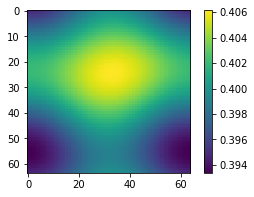

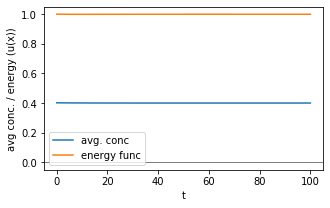

In [15]:
# define parameters.
# L = domain size; Nx = spatial resolution.
# dt = temporal step-size; it = number of iterations.
# L = 5.6 * np.pi
L = 5.6
Nx = 64
dt = 0.001
it = 10000

# m == ubar
m = 0.40
delta = 0.39

tic = time.time()
avgConc, energy, u = dft(L,Nx,it,dt,m,delta)
toc = time.time()
print("time taken: %.3fs" %(toc-tic))

# plot density difference vs L.
u = u.real
dx = np.linspace(0,L,Nx)
fig = plt.figure(figsize=(5,3))
# plt.plot(dx,u)
plt.imshow(u)
plt.colorbar()
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.5f'))
# print(abs(u.max()-u.min()))

# plot change average concentration and energy over time.
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
# ax.set_ylim([-.5,1.1])
plt.xlabel('t')
plt.ylabel('avg conc. / energy (u(x))')
plt.plot(avgConc)
plt.plot(energy)
plt.legend(['avg. conc','energy func'])
plt.axhline(y=0, linewidth=0.5, color='k')
plt.show()

Load the theoretical DFT curves (Pts1.csv and Pts2.csv). These were calculated using *Mathematica*. See lsa.nb for more details.

In [4]:
Pts1 = np.loadtxt('Pts1.csv',delimiter=',')
Pts2 = np.loadtxt('Pts2.csv',delimiter=',')

`odtest` checks if
$$ \lvert \max(u) - \min(u) \rvert < 0.1. $$
If this condition is met, assume that the resulting morphology is that of *disordered* (False). Otherwise *ordered* (True).

In [5]:
def odtest(u):
    if abs(u.max()-u.min()) < 0.1:
        return False
    else:
        return True

Plot the theoretical DFT curves. The value of $\delta_{crit}$ was solved using *Mathematica* and the critical $L$ values are solved in eqn 7.37.

See *lsa.nb* for more details on the *Mathematica* solutions.

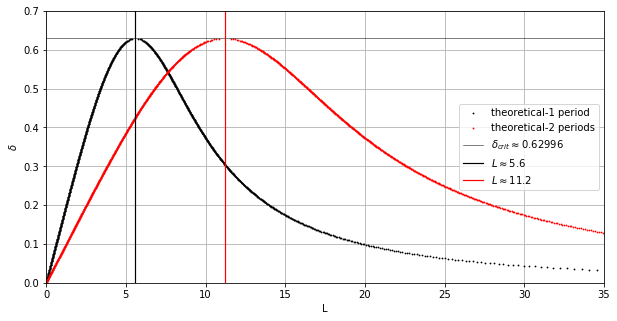

In [12]:
ys1 = Pts1[:,1]
xs1 = Pts1[:,0]

ys2 = Pts2[:,1]
xs2 = Pts2[:,0]

fig2aa = plt.figure(figsize=(10,5))
plt.plot(xs1,ys1,'ko',markersize=0.8,label='theoretical-1 period')
plt.plot(xs2,ys2,'ro',markersize=0.8,label='theoretical-2 periods')
plt.axhline(0.62996,linewidth=0.5,color='k',label=r'$\delta_{crit} \approx0.62996$')
plt.axvline(5.6,linewidth=1.2,color='k',label=r'$L\approx 5.6$')
plt.axvline(5.6*2.,linewidth=1.2,color='r',linestyle='-',label=r'$L\approx 11.2$')
plt.xlim(0,35.)
plt.ylim(0.0,0.7)
plt.xlabel(r'L')
plt.ylabel(r'$\delta$')
plt.legend()
plt.grid()
plt.show()

Investigate points around $\delta \approx 0.63$. Print for each $L$ and $\delta$ value, the amount of orderedness `eta` defined by
$$ \eta = \lvert max(u) - \min(u) \rvert. $$

In [10]:
Nx = 128
dt = 0.001
it = 100000
m = 0.0

Ls = [4.0,4.5,5.0,5.6,6.0,6.5]
deltas = [0.60,0.61,0.62,0.63,0.64]

green = np.zeros((len(Ls)*len(deltas),2))
red = np.zeros((len(Ls)*len(deltas),2))

i = 0
j = 0

tic = time.time()
for L in Ls:
    for delta in deltas:
        avgConc, energy, u = dft(L,Nx,it,dt,m,delta)
        print("L=%.1f, delta=%.2f, eta=%.6f" %(L,delta,abs(u.max()-u.min())))
        if odtest(u) == True:
            green[i,...] = [L,delta]
            i += 1
        else:
            red[j,...] = [L,delta]
            j += 1
            
toc = time.time()
print("time taken: %.3fs" %(toc-tic))

L=4.0, delta=0.60, eta=0.000000
L=4.0, delta=0.61, eta=0.000000
L=4.0, delta=0.62, eta=0.000000
L=4.0, delta=0.63, eta=0.000000
L=4.0, delta=0.64, eta=0.000000
L=4.5, delta=0.60, eta=0.006018
L=4.5, delta=0.61, eta=0.000001
L=4.5, delta=0.62, eta=0.000000
L=4.5, delta=0.63, eta=0.000000
L=4.5, delta=0.64, eta=0.000000
L=5.0, delta=0.60, eta=0.523075
L=5.0, delta=0.61, eta=0.372716
L=5.0, delta=0.62, eta=0.092884
L=5.0, delta=0.63, eta=0.000246
L=5.0, delta=0.64, eta=0.000000
L=5.6, delta=0.60, eta=0.609349
L=5.6, delta=0.61, eta=0.499376
L=5.6, delta=0.62, eta=0.354118
L=5.6, delta=0.63, eta=0.094451
L=5.6, delta=0.64, eta=0.001365
L=6.0, delta=0.60, eta=0.554365
L=6.0, delta=0.61, eta=0.435239
L=6.0, delta=0.62, eta=0.262127
L=6.0, delta=0.63, eta=0.025212
L=6.0, delta=0.64, eta=0.000574
L=6.5, delta=0.60, eta=0.337291
L=6.5, delta=0.61, eta=0.098754
L=6.5, delta=0.62, eta=0.004997
L=6.5, delta=0.63, eta=0.000201
L=6.5, delta=0.64, eta=0.000008
time taken: 168.631s


Plot the results for investigation of $\delta \approx 0.63$.

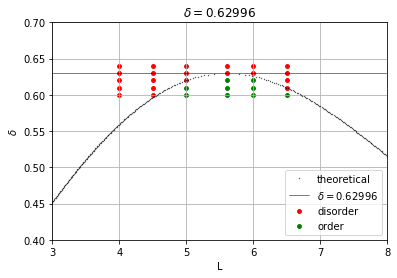

In [16]:
fig2b = plt.figure()
plt.plot(xs1,ys1,'ko',markersize=0.3,label='theoretical')
plt.scatter(red[:,0],red[:,1],color='r',s=15.0,label='disorder')
plt.scatter(green[:,0],green[:,1],color='g',s=15.0,label='order')
plt.axhline(0.62996,linewidth=0.5,color='k',label=r'$\delta = 0.62996$')
plt.xlim(3.,8.)
plt.ylim(0.4,0.7)
plt.xlabel(r'L')
plt.ylabel(r'$\delta$')
plt.legend()
plt.title(r'$\delta = 0.62996$')
plt.grid()
plt.show()

Investigate the points around $\delta \approx 0.55$.

In [28]:
Nx = 128
dt = 0.001
it = 100000
m = 0.0

Ls = [3.5,4.0,4.5]
deltas = [0.54,0.55,0.56]

green = np.zeros((len(Ls)*len(deltas),2))
red = np.zeros((len(Ls)*len(deltas),2))

i = 0
j = 0

tic = time.time()
for L in Ls:
    for delta in deltas:
        avgConc, energy, u = dft(L,Nx,it,dt,m,delta)
        #print("L=%.1f, delta=%.2f, eta=%.6f" %(L,delta,abs(u.max()-u.min())))
        if odtest(u) == True:
            green[i,...] = [L,delta]
            i += 1
        else:
            red[j,...] = [L,delta]
            j += 1
            
toc = time.time()
print("time taken: %.3fs" %(toc-tic))

time taken: 44.477s


Plot the result for the investigation of $\delta \approx 0.55$.

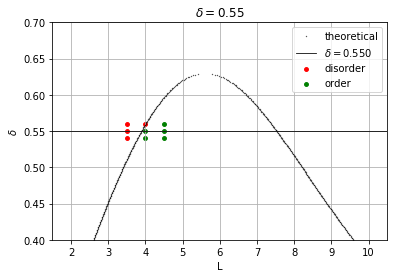

In [30]:
fig2c = plt.figure()
plt.plot(xs1,ys1,'ko',markersize=0.3,label='theoretical')
plt.scatter(red[:,0],red[:,1],color='r',s=15.0,label='disorder')
plt.scatter(green[:,0],green[:,1],color='g',s=15.0,label='order')
plt.axhline(0.55,linewidth=0.8,color='k',label=r'$\delta = %.3f$' %0.55)
plt.xlim(1.5,10.5)
plt.ylim(0.4,0.7)
plt.xlabel(r'L')
plt.ylabel(r'$\delta$')
plt.legend()
plt.title(r'$\delta = 0.55$')
plt.grid()
plt.show()

`oneTwoPeriods` counts the number of peaks.

    Return True, is 1 period detected.
    Return False, if 2 periods are detected
    Return None, if 3 or more periods are detected.

In [24]:
def oneTwoPeriods(u):
    indexes = detect_peaks(u)
    if len(indexes) == 1:
        return True
    if len(indexes) == 2:
        return False

Generate for a large range of $L$ and $\delta$. This result is used in the thesis, for figure 7.5a.

In [5]:
Nx = 128
dt = 0.001
it = 100000
m = 0.0

Ls = np.arange(1.0,24.0,0.2)
deltas = np.arange(0.40,0.65,0.01)
Us = np.zeros((len(Ls)*len(deltas),Nx))

green = np.zeros((len(Ls)*len(deltas),2))
red = np.zeros((len(Ls)*len(deltas),2))
blue = np.zeros((len(Ls)*len(deltas),2))
yellow = np.zeros((len(Ls)*len(deltas),2))

i = 0

tic = time.time()
for delta in deltas:
    for L in Ls:
        avgConc, energy, u = dft(L,Nx,it,dt,m,delta)
        Us[i,:] = u.real
        i += 1

toc = time.time()
print("time taken: %.3fs" %(toc-tic))

time taken: 13610.093s


Save data array.

In [11]:
#np.savetxt("uArrs/DFT_Us_delta_%.2f-%.2f_V_%.1f-%.1f" %(deltas.min(),deltas.max(),Ls.min(),Ls.max()), Us)

Load the range of parameters used, and the data array.

In [22]:
Ls = np.arange(1.0,24.0,0.2)
deltas = np.arange(0.40,0.65,0.01)
Us = np.loadtxt("uArrs/DFT_Us_delta_0.40-0.64_V_1.0-23.8")

Sort data generated according to number of periods.

    red = disordered,
    green = 1 period,
    blue = 2 periods,
    yellow = 3 or more periods.

In [25]:
green = np.zeros((len(Ls)*len(deltas),2))
red = np.zeros((len(Ls)*len(deltas),2))
blue = np.zeros((len(Ls)*len(deltas),2))
yellow = np.zeros((len(Ls)*len(deltas),2))

i = 0
j = 0
for ii in range(Us.shape[0]):
    u = Us[ii]
    L = Ls[(ii%len(Ls))]
    delta = deltas[(ii/(len(Ls)))]
    
    if odtest(u) == True:
        if oneTwoPeriods(u.real) == True:
            green[i,...] = [L,delta]
        elif oneTwoPeriods(u.real) == False:
            blue[i,...] = [L,delta]
        else:
            yellow[i,...] = [L,delta]
        i += 1
    else:
        red[j,...] = [L,delta]
        j += 1

Plot the resulting scatter plot of lamellar periodicity.

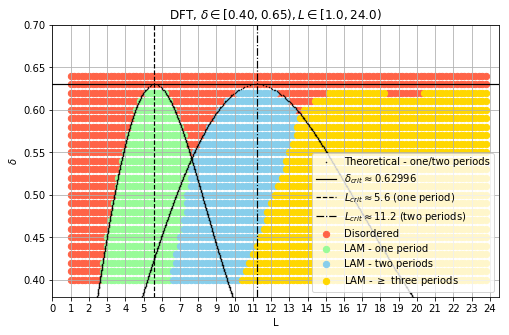

In [26]:
delta1 = 0.45
delta2 = 0.50
fig2d = plt.figure(figsize=(8,5))
plt.plot(xs1,ys1,'ko',markersize=0.5,label='Theoretical - one/two periods')
plt.plot(xs2,ys2,'ko',markersize=0.5)
plt.scatter(red[:,0],red[:,1],color='tomato',s=40.0,label='Disordered')
plt.scatter(green[:,0],green[:,1],color='palegreen',s=40.0,label='LAM - one period')
plt.scatter(blue[:,0],blue[:,1],color='skyblue',s=40.0,label='LAM - two periods')
plt.scatter(yellow[:,0],yellow[:,1],color='gold',s=40.0,label=r'LAM - $\geq$ three periods')
plt.axhline(0.62996,linewidth=1.2,color='k', label=r'$\delta_{crit} \approx 0.62996$')
plt.axvline(5.6,linewidth=1.2,color='k',linestyle='--',label=r'$L_{crit}\approx 5.6$ (one period)')
plt.axvline(5.6*2.,linewidth=1.2,color='k',linestyle='-.',label=r'$L_{crit} \approx 11.2$ (two periods)')
plt.xlim(0.5,24.5)
plt.xticks(np.arange(0, 24.+0.5, 1.0))
plt.ylim(0.38,0.70)
plt.xlabel(r'L')
plt.ylabel(r'$\delta$')
plt.legend()
plt.title(r'DFT, $\delta \in [0.40,0.65), L \in [1.0,24.0)$')
plt.legend(loc='lower right', ncol=1)
plt.grid()
#fig2d = plt.savefig("DFT-period.pdf", bbox_inches='tight')
plt.show()

The result below is not used. It investigates the jump of the equilibrium morphology from one-to-two periods.

time taken: 71.990s


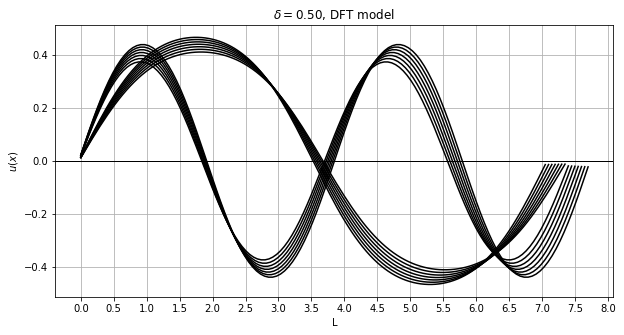

In [54]:
Nx = 128
dt = 0.001
it = 100000
m = 0.0

Ls = np.arange(7.0,7.7,0.05)
deltas = [0.50]

green = np.zeros((len(Ls)*len(deltas),2))
red = np.zeros((len(Ls)*len(deltas),2))
blue = np.zeros((len(Ls)*len(deltas),2))

i = 0
j = 0

fig2e = plt.figure(figsize=(10,5))
tic = time.time()
for L in Ls:
    LL = np.linspace(0,L,Nx)
    for delta in deltas:
        avgConc, energy, u = dft(L,Nx,it,dt,m,delta)
        if ((L > 7.0) and (delta==0.50) and (L < 11.0)):
            plt.plot(LL,u,label=r'$L=%.2f$' %L, color='k')
        if odtest(u) == True:
            if oneTwoPeriods(u.real) == True:
                green[i,...] = [L,delta]
            else:
                blue[i,...] = [L,delta]
            i += 1
        else:
            red[j,...] = [L,delta]
            j += 1

plt.axhline(0.0,linewidth=1.0,color='k')
plt.title(r'$\delta = %.2f$, DFT model' %(0.50))
plt.xlabel(r'L')
plt.xticks(np.arange(0., 8.+0.5, .5))
plt.grid()
plt.ylabel(r'$u(x)$')
#fig2e = plt.savefig("period-split.pdf", bbox_inches='tight')
plt.show()
toc = time.time()
print("time taken: %.3fs" %(toc-tic))